# Set-Up

In [1]:
!pip3 install datasets
!pip install accelerate -U

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize
import transformers
from transformers import AutoImageProcessor, DefaultDataCollator, AutoModelForImageClassification, BeitForImageClassification, Trainer, TrainingArguments, EarlyStoppingCallback, ResNetForImageClassification
from datasets import load_dataset, DatasetDict
from PIL import Image
import accelerate
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, balanced_accuracy_score
import datasets

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


# Importar datos

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip "/content/drive/MyDrive/Colab Notebooks/archive.zip" -d "/kaggle"
!unzip "/kaggle/archive.zip" -d /kaggle/

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: /ka

# Cargar datos

In [5]:
checkpoint = "microsoft/resnet-50"

dataset = load_dataset("imagefolder", data_dir="/kaggle/Alzheimer_s Dataset")

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

print(labels)

Resolving data files:   0%|          | 0/5121 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1279 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


# Visualizar los datos

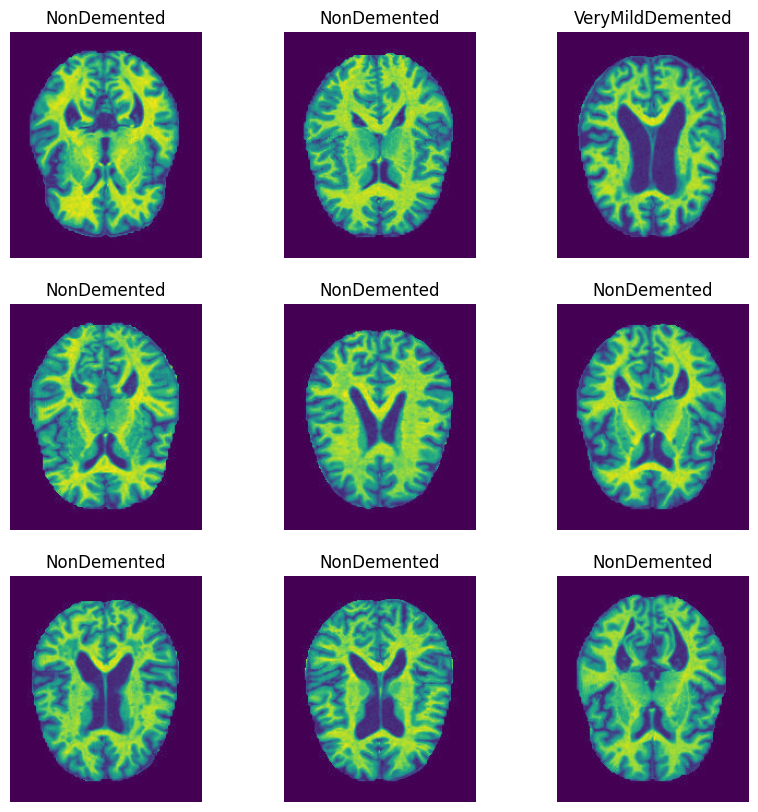

In [6]:
plt.figure(figsize=(10, 10))
for i in range(9):
    index = random.randint(0, len(dataset["train"]) - 1)
    ax = plt.subplot(3, 3, i + 1)
    img = dataset["train"][index]["image"]
    label = id2label[str(dataset["train"][index]["label"])]
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()

# Preprocesamiento de los datos

In [7]:
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

def process_example(example):
    inputs = image_processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

def transform(example_batch):
    images = [img.convert("RGB") if img.mode != "RGB" else img for img in example_batch['image']]
    inputs = image_processor(images, return_tensors='pt')
    inputs['labels'] = example_batch['label']

    return inputs

proc_dataset = dataset.with_transform(transform)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

print(image_processor)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



# Data Augmentation

In [8]:
augmentation_transforms = Compose([
    Resize(size=(224,224)),
    RandomRotation(degrees=45),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ToTensor()
])

normal_transforms = Compose([
    Resize(size=(224,224)),
    ToTensor()
])

def transform(example_batch, is_aug=True):
    if is_aug:
        images = [augmentation_transforms(img.convert("RGB")) for img in example_batch['image']]
    else:
        images = [normal_transforms(img.convert("RGB")) for img in example_batch['image']]

    inputs = {
        'pixel_values': torch.stack(images),
        'labels': example_batch['label']
    }
    return inputs

new_transforms = Compose([
    ToTensor(),
])

def new_transform(example_batch):
    images = [new_transforms(img.convert("RGB")) for img in example_batch['image']]

    inputs = {
        'pixel_values': torch.stack(images),
        'labels': example_batch['label']
    }
    return inputs

normal_train_dataset = dataset.with_transform(lambda batch: transform(batch, is_aug=False))

aug_train_dataset = dataset.with_transform(lambda batch: transform(batch, is_aug=True))

<class 'datasets.arrow_dataset.Dataset'>


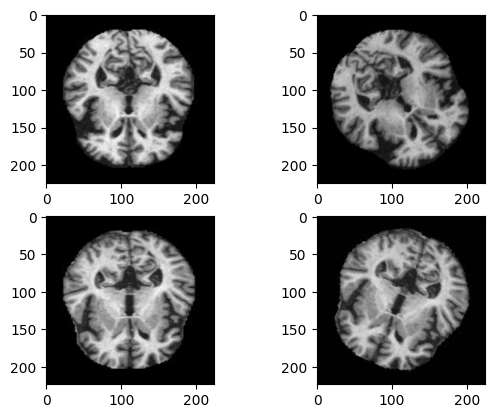

In [9]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(normal_train_dataset['train'][11]['pixel_values'].permute(1, 2, 0))
axarr[0,1].imshow(aug_train_dataset['train'][11]['pixel_values'].permute(1, 2, 0))
axarr[1,0].imshow(normal_train_dataset['train'][21]['pixel_values'].permute(1, 2, 0))
axarr[1,1].imshow(aug_train_dataset['train'][21]['pixel_values'].permute(1, 2, 0))

print(type(dataset['train']))

combined_train_dataset = DatasetDict({"train": datasets.concatenate_datasets([normal_train_dataset["train"], aug_train_dataset["train"]])})
combined_test_dataset = DatasetDict({"test": datasets.concatenate_datasets([normal_train_dataset["test"], aug_train_dataset["test"]])})

combined_dataset = DatasetDict({
    'train': combined_train_dataset['train'],
    'test': combined_test_dataset['test']
})

combined_dataset = combined_dataset.shuffle(seed=42)
new_dataset = combined_dataset.with_transform(lambda batch: new_transform(batch))

# Modelo

##TRAIN1

In [10]:
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.02)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=0.002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_strategy="epoch",
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.002,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.6,
    amsgrad=False
)

scheduler = transformers.get_polynomial_decay_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size*0.1,
    num_training_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()
print(history)
trainer.evaluate(eval_dataset=new_dataset['test'])

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1245233191.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alejandra-roldan2000 (alejandra-roldan2000-unir) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.270100,1.601639,0.501955,0.704875,0.501955,0.526238
2,0.020100,0.715052,0.752150,0.750976,0.752150,0.750120
3,0.013800,0.770647,0.749805,0.747198,0.749805,0.743525
4,0.022000,0.726182,0.752932,0.749976,0.752932,0.749141
5,0.022900,0.796266,0.744332,0.752235,0.744332,0.737350
6,0.016900,0.753909,0.758405,0.755886,0.758405,0.752840
7,0.023200,0.796160,0.757623,0.755803,0.757623,0.750047


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1127, training_loss=0.1343218729217283, metrics={'train_runtime': 734.0341, 'train_samples_per_second': 279.061, 'train_steps_per_second': 4.387, 'total_flos': 1.110961430245675e+18, 'train_loss': 0.1343218729217283, 'epoch': 7.0})


{'eval_loss': 0.7539089918136597,
 'eval_accuracy': 0.7584050039093041,
 'eval_precision': 0.7558862625850896,
 'eval_recall': 0.7584050039093041,
 'eval_f1': 0.7528403922779626,
 'eval_runtime': 8.0043,
 'eval_samples_per_second': 319.577,
 'eval_steps_per_second': 19.989,
 'epoch': 7.0}

##TRAIN2

In [12]:
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.02)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=0.002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_strategy="epoch",
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.002,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.6,
    amsgrad=False
)

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size*0.1,
    num_training_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()
print(history)
trainer.evaluate(eval_dataset=new_dataset['test'])

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3251353179.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.242800,0.990316,0.694292,0.717744,0.694292,0.685990
2,0.029700,0.752941,0.780297,0.783450,0.780297,0.780084
3,0.065400,0.872612,0.756059,0.759075,0.756059,0.752755
4,0.192100,5.280266,0.394058,0.698138,0.394058,0.262936
5,0.034000,0.840949,0.759969,0.768269,0.759969,0.756196
6,0.003500,0.785105,0.776388,0.774344,0.776388,0.773818
7,0.117000,2.475277,0.339328,0.753074,0.339328,0.323021


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1127, training_loss=0.16212726120953552, metrics={'train_runtime': 722.9671, 'train_samples_per_second': 283.332, 'train_steps_per_second': 4.454, 'total_flos': 1.110961430245675e+18, 'train_loss': 0.16212726120953552, 'epoch': 7.0})


{'eval_loss': 0.7529410719871521,
 'eval_accuracy': 0.7802971071149335,
 'eval_precision': 0.783450286615533,
 'eval_recall': 0.7802971071149335,
 'eval_f1': 0.7800835174896518,
 'eval_runtime': 8.3204,
 'eval_samples_per_second': 307.438,
 'eval_steps_per_second': 19.23,
 'epoch': 7.0}

##TRAIN3

In [13]:
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.02)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=0.002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_strategy="epoch",
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.002,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.6,
    amsgrad=True
)

scheduler = transformers.get_polynomial_decay_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size*0.1,
    num_training_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()
print(history)
trainer.evaluate(eval_dataset=new_dataset['test'])

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-972183082.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.266200,1.982335,0.490227,0.674923,0.490227,0.502918
2,0.036600,0.811661,0.752932,0.758159,0.752932,0.744590
3,0.013000,0.981882,0.724785,0.751719,0.724785,0.706176
4,0.012900,0.826370,0.746677,0.754925,0.746677,0.736940
5,0.016400,0.946013,0.736513,0.756800,0.736513,0.720308
6,0.021300,0.951893,0.742768,0.762617,0.742768,0.728914
7,0.031200,0.962897,0.721658,0.749884,0.721658,0.701623


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1127, training_loss=0.134478446264762, metrics={'train_runtime': 746.4088, 'train_samples_per_second': 274.434, 'train_steps_per_second': 4.314, 'total_flos': 1.110961430245675e+18, 'train_loss': 0.134478446264762, 'epoch': 7.0})


{'eval_loss': 0.811661422252655,
 'eval_accuracy': 0.7529319781078968,
 'eval_precision': 0.75815853523072,
 'eval_recall': 0.7529319781078968,
 'eval_f1': 0.7445897992810808,
 'eval_runtime': 8.2454,
 'eval_samples_per_second': 310.235,
 'eval_steps_per_second': 19.405,
 'epoch': 7.0}

##TRAIN4

In [14]:
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.02)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=0.002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_strategy="epoch",
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.002,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.6,
    amsgrad=True
)

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size*0.1,
    num_training_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()
print(history)
trainer.evaluate(eval_dataset=new_dataset['test'])

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-143846664.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.292600,1.092182,0.673182,0.720791,0.673182,0.644112
2,0.034800,0.776126,0.752932,0.759263,0.752932,0.752717
3,0.066100,2.083157,0.612197,0.700719,0.612197,0.548322
4,0.152900,0.889798,0.645817,0.690436,0.645817,0.656643
5,0.024400,0.927894,0.758405,0.767609,0.758405,0.757735
6,0.004000,0.773366,0.775606,0.775897,0.775606,0.772132
7,0.071400,0.910236,0.693511,0.730062,0.693511,0.698147


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1127, training_loss=0.1662475362158948, metrics={'train_runtime': 741.4602, 'train_samples_per_second': 276.266, 'train_steps_per_second': 4.343, 'total_flos': 1.110961430245675e+18, 'train_loss': 0.1662475362158948, 'epoch': 7.0})


{'eval_loss': 0.7733659148216248,
 'eval_accuracy': 0.7756059421422987,
 'eval_precision': 0.7758967176690467,
 'eval_recall': 0.7756059421422987,
 'eval_f1': 0.7721318814629206,
 'eval_runtime': 8.1424,
 'eval_samples_per_second': 314.157,
 'eval_steps_per_second': 19.65,
 'epoch': 7.0}

##TRAIN5

In [16]:
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.02)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=0.002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_strategy="epoch",
)

optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr=0.002,
    lr_decay=0.0,
    weight_decay=0.6,
    eps=1e-08
)

scheduler = transformers.get_polynomial_decay_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size*0.1,
    num_training_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()
print(history)
trainer.evaluate(eval_dataset=new_dataset['test'])

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-250353041.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.138200,1.060248,0.502737,0.426715,0.502737,0.343431
2,1.151600,1.107268,0.500391,0.250783,0.500391,0.334116
3,1.144000,1.076563,0.500391,0.367346,0.500391,0.335321
4,1.119800,1.087883,0.500391,0.367346,0.500391,0.335321
5,1.154400,1.086478,0.501173,0.600861,0.501173,0.335502
6,1.140900,1.111848,0.501173,0.600861,0.501173,0.335502


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

TrainOutput(global_step=966, training_loss=1.147205538878036, metrics={'train_runtime': 633.2248, 'train_samples_per_second': 323.487, 'train_steps_per_second': 5.085, 'total_flos': 9.522526544962929e+17, 'train_loss': 1.147205538878036, 'epoch': 6.0})


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0602478981018066,
 'eval_accuracy': 0.5027365129007036,
 'eval_precision': 0.4267145862401134,
 'eval_recall': 0.5027365129007036,
 'eval_f1': 0.3434312522470633,
 'eval_runtime': 8.3002,
 'eval_samples_per_second': 308.186,
 'eval_steps_per_second': 19.277,
 'epoch': 6.0}

##TRAIN6

In [17]:
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.02)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=0.002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_strategy="epoch",
)

optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr=0.002,
    lr_decay=0.0,
    weight_decay=0.6,
    eps=1e-08
)

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size*0.1,
    num_training_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()
print(history)
trainer.evaluate(eval_dataset=new_dataset['test'])

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3144450367.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.113600,1.103189,0.501955,0.601057,0.501955,0.337230
2,1.106800,1.060019,0.500391,0.250391,0.500391,0.333768
3,1.112500,1.046335,0.501173,0.425921,0.501173,0.337042
4,1.081700,1.147818,0.507428,0.439761,0.507428,0.368975
5,1.123100,1.012702,0.501173,0.600861,0.501173,0.335502
6,1.111300,1.051827,0.501173,0.600861,0.501173,0.335502
7,1.093900,1.012716,0.500391,0.250391,0.500391,0.333768
8,1.087700,1.025222,0.500391,0.250391,0.500391,0.333768
9,1.100900,1.023472,0.501173,0.425920,0.501173,0.335673


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

TrainOutput(global_step=1449, training_loss=1.1089471576129921, metrics={'train_runtime': 921.6761, 'train_samples_per_second': 222.247, 'train_steps_per_second': 3.494, 'total_flos': 1.4283789817444393e+18, 'train_loss': 1.1089471576129921, 'epoch': 9.0})


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.1478183269500732,
 'eval_accuracy': 0.5074276778733385,
 'eval_precision': 0.43976052892593404,
 'eval_recall': 0.5074276778733385,
 'eval_f1': 0.3689751305075777,
 'eval_runtime': 8.2084,
 'eval_samples_per_second': 311.63,
 'eval_steps_per_second': 19.492,
 'epoch': 9.0}

##TRAIN7

In [19]:
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.02)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=0.002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_strategy="epoch",
)

optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=0.002,
    alpha=0.9,
    eps=1e-08,
    weight_decay=0.6,
    momentum=0.9
)

scheduler = transformers.get_polynomial_decay_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size*0.1,
    num_training_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()
print(history)
trainer.evaluate(eval_dataset=new_dataset['test'])

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-389297545.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.297900,14.504349,0.500391,0.250391,0.500391,0.333768
2,1.264500,1.211712,0.500391,0.250391,0.500391,0.333768
3,1.261600,1.227427,0.500391,0.250391,0.500391,0.333768
4,1.252400,1.238331,0.500391,0.250391,0.500391,0.333768
5,1.267400,1.218375,0.500391,0.250391,0.500391,0.333768
6,1.262000,1.247395,0.500391,0.250391,0.500391,0.333768


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

TrainOutput(global_step=966, training_loss=1.2793445044175933, metrics={'train_runtime': 614.4896, 'train_samples_per_second': 333.35, 'train_steps_per_second': 5.24, 'total_flos': 9.522526544962929e+17, 'train_loss': 1.2793445044175933, 'epoch': 6.0})


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 14.504348754882812,
 'eval_accuracy': 0.5003909304143862,
 'eval_precision': 0.25039108324097514,
 'eval_recall': 0.5003909304143862,
 'eval_f1': 0.33376779100073706,
 'eval_runtime': 8.2892,
 'eval_samples_per_second': 308.595,
 'eval_steps_per_second': 19.302,
 'epoch': 6.0}

##TRAIN8

In [20]:
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.02)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=0.002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_strategy="epoch",
)

optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=0.002,
    alpha=0.9,
    eps=1e-08,
    weight_decay=0.6,
    momentum=0.9
)

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size*0.1,
    num_training_steps=training_args.num_train_epochs*training_args.per_device_train_batch_size)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()
print(history)
trainer.evaluate(eval_dataset=new_dataset['test'])

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2929676597.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.300100,84.745064,0.500391,0.250391,0.500391,0.333768
2,1.263900,1.266677,0.500391,0.250391,0.500391,0.333768
3,1.235500,1.243081,0.500391,0.250391,0.500391,0.333768
4,1.232500,1.238241,0.500391,0.250391,0.500391,0.333768
5,1.252800,1.247596,0.500391,0.250391,0.500391,0.333768
6,1.249900,1.246140,0.500391,0.250391,0.500391,0.333768


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

TrainOutput(global_step=966, training_loss=1.2680655720317833, metrics={'train_runtime': 613.038, 'train_samples_per_second': 334.139, 'train_steps_per_second': 5.253, 'total_flos': 9.522526544962929e+17, 'train_loss': 1.2680655720317833, 'epoch': 6.0})


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 84.74506378173828,
 'eval_accuracy': 0.5003909304143862,
 'eval_precision': 0.25039108324097514,
 'eval_recall': 0.5003909304143862,
 'eval_f1': 0.33376779100073706,
 'eval_runtime': 8.3464,
 'eval_samples_per_second': 306.48,
 'eval_steps_per_second': 19.17,
 'epoch': 6.0}

##TRAIN9

In [21]:
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.02)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=0.002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_strategy="epoch",
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.002,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.6,
    amsgrad=False
)

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.2,
    patience=2,
    threshold=0.01,
    min_lr=1e-8
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()
print(history)
trainer.evaluate(eval_dataset=new_dataset['test'])

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2351100217.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.347700,1.013129,0.647381,0.647738,0.647381,0.621812
2,0.137100,1.750944,0.637217,0.601890,0.637217,0.594569
3,0.080900,0.942421,0.687256,0.688361,0.687256,0.679966
4,0.074300,1.662434,0.556685,0.759121,0.556685,0.515210
5,0.063600,0.776020,0.723221,0.716881,0.723221,0.716474
6,0.105000,1.048099,0.657545,0.678819,0.657545,0.624196
7,0.105100,0.949047,0.634871,0.683798,0.634871,0.637224
8,0.159400,1.791036,0.496482,0.738069,0.496482,0.481609
9,0.002400,0.785683,0.738077,0.752978,0.738077,0.737598
10,0.001300,0.735333,0.766224,0.769239,0.766224,0.762975


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=2415, training_loss=0.10010554864154222, metrics={'train_runtime': 1528.8781, 'train_samples_per_second': 133.981, 'train_steps_per_second': 2.106, 'total_flos': 2.380631636240732e+18, 'train_loss': 0.10010554864154222, 'epoch': 15.0})


{'eval_loss': 0.7186567187309265,
 'eval_accuracy': 0.7740422204847537,
 'eval_precision': 0.7739567184669641,
 'eval_recall': 0.7740422204847537,
 'eval_f1': 0.7731466136422619,
 'eval_runtime': 8.1572,
 'eval_samples_per_second': 313.586,
 'eval_steps_per_second': 19.614,
 'epoch': 15.0}

##TRAIN10

In [22]:
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.02)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=0.002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    save_strategy="epoch",
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.002,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.6,
    amsgrad=True
)

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.2,
    patience=2,
    threshold=0.01,
    min_lr=1e-8
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()
print(history)
trainer.evaluate(eval_dataset=new_dataset['test'])

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3492627720.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.319500,2.036635,0.529320,0.679335,0.529320,0.444719
2,0.154100,2.107323,0.565285,0.710493,0.565285,0.463552
3,0.108500,1.392804,0.630962,0.704137,0.630962,0.602255
4,0.087200,3.694570,0.290070,0.652842,0.290070,0.227980
5,0.091000,2.352875,0.439406,0.746451,0.439406,0.455241
6,0.160300,1.401958,0.637998,0.630223,0.637998,0.615726
7,0.091300,1.461122,0.545739,0.723196,0.545739,0.513793
8,0.158600,0.831497,0.673964,0.700519,0.673964,0.644726
9,0.092600,1.291222,0.606724,0.756004,0.606724,0.636570
10,0.096100,2.904405,0.535575,0.627394,0.535575,0.412572


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=2737, training_loss=0.10483719977258596, metrics={'train_runtime': 1800.058, 'train_samples_per_second': 113.796, 'train_steps_per_second': 1.789, 'total_flos': 2.6980491877394964e+18, 'train_loss': 0.10483719977258596, 'epoch': 17.0})


{'eval_loss': 0.7796651124954224,
 'eval_accuracy': 0.7318217357310399,
 'eval_precision': 0.7419052347512761,
 'eval_recall': 0.7318217357310399,
 'eval_f1': 0.73219926956153,
 'eval_runtime': 8.2267,
 'eval_samples_per_second': 310.938,
 'eval_steps_per_second': 19.449,
 'epoch': 17.0}